In [1]:
#必要なデータを読み込む(ジムの利用履歴データ)
import pandas as pd
uselog = pd.read_csv('./data003/use_log.csv')
print(len(uselog))
uselog.head()

197428


,log_id,customer_id,usedate
0,L00000049012330,AS009373,2018-04-01
1,L00000049012331,AS015315,2018-04-01
2,L00000049012332,AS040841,2018-04-01
3,L00000049012333,AS046594,2018-04-01
4,L00000049012334,AS073285,2018-04-01


In [2]:
#2019年3月末時点での会員データ
customer = pd.read_csv('./data003/customer_master.csv')
print(len(customer))
customer.head()

4192


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0


In [3]:
#会員区分データ(オールタイム、デイタイム)
class_master = pd.read_csv('./data003/class_master.csv')
print(len(class_master))
class_master.head()

3


,class,class_name,price
0,C01,オールタイム,10500
1,C02,デイタイム,7500
2,C03,ナイト,6000


In [4]:
#キャンペーン区分データ(入会無料等)
campaign_master = pd.read_csv('./data003/campaign_master.csv')
print(len(campaign_master))
campaign_master.head()

3


,campaign_id,campaign_name
0,CA1,通常
1,CA2,入会費半額
2,CA3,入会費無料


In [5]:
#顧客データの整形
#顧客データに、会員区分のclass_masterとキャンペーン区分のcampain_masterを結合する
customer_join = pd.merge(customer, class_master, on="class", how="left")
customer_join = pd.merge(customer_join, campaign_master, on="campaign_id", how="left")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name
0,OA832399,XXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
1,PL270116,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
2,OA974876,XXXXX,C01,M,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
3,HD024127,XXXXX,C01,F,2015-05-01 00:00:00,NaN,CA1,0,オールタイム,10500,通常
4,HD661448,XXXXX,C03,F,2015-05-01 00:00:00,NaN,CA1,0,ナイト,6000,通常


In [6]:
#ジョイン後の欠損値の確認
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
dtype: int64

In [7]:
#顧客データの基礎集計
#会員区分
customer_join.groupby("class_name").count()["customer_id"]

class_name
オールタイム    2045
デイタイム     1019
ナイト       1128
Name: customer_id, dtype: int64

In [8]:
#キャンペーン区分
customer_join.groupby("campaign_name").count()["customer_id"]

campaign_name
入会費半額     650
入会費無料     492
通常       3050
Name: customer_id, dtype: int64

In [9]:
#性別区分
customer_join.groupby("gender").count()["customer_id"]

gender
F    1983
M    2209
Name: customer_id, dtype: int64

In [10]:
#退会区分
customer_join.groupby("is_deleted").count()["customer_id"]

is_deleted
0    2842
1    1350
Name: customer_id, dtype: int64

In [11]:
#入会人数を集計(start_date列)
customer_join["start_date"] = pd.to_datetime(customer_join["start_date"])
customer_start = customer_join.loc[customer_join["start_date"] > pd.to_datetime("20180401")]
print(len(customer_start))

1361


In [12]:
#最新顧客データの基礎集計
#最新月のユーザーに飲み絞り込みを行う
#2019年3月に退会、在籍しているユーザーに絞り込む
customer_join["end_date"] = pd.to_datetime(customer_join["end_date"])
customer_newer = customer_join.loc[(customer_join["end_date"] >= pd.to_datetime("20190331")) | (customer_join["end_date"].isna())]
print(len(customer_newer))
customer_newer["end_date"].unique()

2953


array([                          'NaT', '2019-03-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [13]:
#会員区分
customer_newer.groupby("class_name").count()["customer_id"]

class_name
オールタイム    1444
デイタイム      696
ナイト        813
Name: customer_id, dtype: int64

In [14]:
#キャンペーン区分
customer_newer.groupby("campaign_name").count()["customer_id"]

campaign_name
入会費半額     311
入会費無料     242
通常       2400
Name: customer_id, dtype: int64

In [15]:
#性別毎
customer_newer.groupby("gender").count()["customer_id"]

gender
F    1400
M    1553
Name: customer_id, dtype: int64

In [16]:
#利用履歴データを集計
#データ集計に時間的な要素を取り入れる
#月利用回数の平均値、中央値、最大値、最小値と定期的に利用しているかのフラグを作成し、顧客データを追加していく

#顧客毎の月利用回数を集計したデータを作成
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月","customer_id"], as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [17]:
#ここから顧客毎に絞り込み、平均値、中央値、最大値、最小値を集計する
uselog_customer = uselog_months.groupby("customer_id").agg(["mean", "median", "max", "min"])["count"]
uselog_customer = uselog_customer.reset_index(drop=False)
uselog_customer.head()

,customer_id,mean,median,max,min
0,AS002855,4.500000,5.0,7,2
1,AS008805,4.000000,4.0,8,1
2,AS009013,2.000000,2.0,2,2
3,AS009373,5.083333,5.0,7,3
4,AS015233,7.545455,7.0,11,4


In [18]:
#利用履歴データから定期利用フラグを作成
#定期的にジムを利用しているユーザーを特定
#顧客毎に月／曜日別に集計を行い、最大値が4以上の曜日が1ヶ月でもあったユーザーはフラグ1とする

#最初に顧客毎に月／曜日別に集計を行う
uselog["weekday"] = uselog["usedate"].dt.weekday
uselog_weekday = uselog.groupby(["customer_id", "年月", "weekday"], as_index = False).count()[["customer_id", "年月", "weekday", "log_id"]]
uselog_weekday.rename(columns={"log_id":"count"}, inplace=True)
uselog_weekday.head()

,customer_id,年月,weekday,count
0,AS002855,201804,5,4
1,AS002855,201805,2,1
2,AS002855,201805,5,4
3,AS002855,201806,5,5
4,AS002855,201807,1,1


In [19]:
#顧客毎の各月の最大値を取得し、その最大値が4以上の場合にフラグを立てる。
uselog_weekday = uselog_weekday.groupby("customer_id", as_index=False).max()[["customer_id", "count"]]
uselog_weekday["routine_flg"] = 0
uselog_weekday["routine_flg"] = uselog_weekday["routine_flg"].where(uselog_weekday["count"] < 4, 1)
uselog_weekday.head()

,customer_id,count,routine_flg
0,AS002855,5,1
1,AS008805,4,1
2,AS009013,2,0
3,AS009373,5,1
4,AS015233,5,1


In [20]:
#uselog_customer, uselog_weekdayを、customer_joinと結合する
customer_join = pd.merge(customer_join, uselog_customer, on="customer_id", how="left")
customer_join = pd.merge(customer_join, uselog_weekday[["customer_id", "routine_flg"]], on="customer_id", how="left")
customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1


In [21]:
#欠損値
customer_join.isnull().sum()

customer_id         0
name                0
class               0
gender              0
start_date          0
end_date         2842
campaign_id         0
is_deleted          0
class_name          0
price               0
campaign_name       0
mean                0
median              0
max                 0
min                 0
routine_flg         0
dtype: int64

In [22]:
#会員期間の計算
#会員期間は、start_dateとend_dateの差になるが、2019年3月までに退会していないユーザーに関しては、end_dateに欠損値が入っているので、差の計算ができない。そのため、2019年4月をend_dateとして会員期間を算出する。
#月単位での集計
from dateutil.relativedelta import relativedelta
customer_join["calc_date"] = customer_join["end_date"]
customer_join["calc_date"] = customer_join["calc_date"].fillna(pd.to_datetime("20190430"))
customer_join["membership_period"] = 0
for i in range(len(customer_join)):
    delta = relativedelta(customer_join["calc_date"].iloc[i], customer_join["start_date"].iloc[i])
    customer_join["membership_period"].iloc[i] = delta.years*12 + delta.months
customer_join.head()

/home/vagrant/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaT,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaT,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


In [23]:
#顧客行動の各種統計量を把握する
customer_join[["mean", "median", "max", "min"]].describe()

,mean,median,max,min
count,4192.000000,4192.000000,4192.000000,4192.000000
mean,5.333127,5.250596,7.823950,3.041269
std,1.777533,1.874874,2.168959,1.951565
min,1.000000,1.000000,1.000000,1.000000
25%,4.250000,4.000000,7.000000,2.000000
50%,5.000000,5.000000,8.000000,3.000000
75%,6.416667,6.500000,9.000000,4.000000
max,12.000000,12.000000,14.000000,12.000000


In [24]:
#routine_flgを集計
customer_join.groupby("routine_flg").count()["customer_id"]

routine_flg
0     779
1    3413
Name: customer_id, dtype: int64

(array([857., 774., 395., 368., 311., 331., 323., 237., 288., 308.]),
 array([ 1. ,  5.6, 10.2, 14.8, 19.4, 24. , 28.6, 33.2, 37.8, 42.4, 47. ]),
 <BarContainer object of 10 artists>)

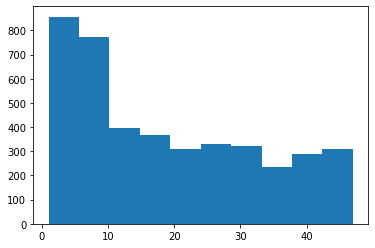

In [25]:
#会員期間の分布を可視化
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(customer_join["membership_period"])

In [26]:
#退会ユーザー
customer_end = customer_join.loc[customer_join["is_deleted"]==1]
customer_end.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,1350.0,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000,1350.000000
mean,1.0,8595.555556,3.865474,3.621852,6.461481,1.821481,0.456296,8.026667
std,0.0,1949.163652,1.246385,1.270847,2.584021,0.976361,0.498271,5.033692
min,1.0,6000.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,1.0,6000.000000,3.000000,3.000000,4.000000,1.000000,0.000000,4.000000
50%,1.0,7500.000000,4.000000,4.000000,7.000000,2.000000,0.000000,7.000000
75%,1.0,10500.000000,4.666667,4.500000,8.000000,2.000000,1.000000,11.000000
max,1.0,10500.000000,9.000000,9.000000,13.000000,8.000000,1.000000,23.000000


In [27]:
#継続ユーザー
customer_stay = customer_join.loc[customer_join["is_deleted"]==0]
customer_stay.describe()

,is_deleted,price,mean,median,max,min,routine_flg,membership_period
count,2842.0,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000,2842.000000
mean,0.0,8542.927516,6.030288,6.024279,8.471147,3.620690,0.984166,23.970443
std,0.0,1977.189779,1.553587,1.599765,1.571048,2.030488,0.124855,13.746761
min,0.0,6000.000000,3.166667,3.000000,5.000000,1.000000,0.000000,1.000000
25%,0.0,6000.000000,4.833333,5.000000,7.000000,2.000000,1.000000,12.000000
50%,0.0,7500.000000,5.583333,5.500000,8.000000,3.000000,1.000000,24.000000
75%,0.0,10500.000000,7.178030,7.000000,10.000000,5.000000,1.000000,35.000000
max,0.0,10500.000000,12.000000,12.000000,14.000000,12.000000,1.000000,47.000000


In [28]:
#customer_joinをCSV出力
customer_join.to_csv("customer_join.csv", index=False)

In [29]:
#顧客の行動を予測する
#データを読み込んで確認
import pandas as pd
uselog = pd.read_csv('./data003/use_log.csv')
uselog.isnull().sum()

log_id         0
customer_id    0
usedate        0
dtype: int64

In [30]:
customer = pd.read_csv('customer_join.csv')
customer.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

In [31]:
"""顧客データをグループ化する"""
#退会しているかどうかではなく、利用履歴に基づいたグループ化を行う
#その場合、あらかじめ決められた正解がないので、教師なし学習のクラスタリングを用いる。
#顧客のグループ化を行う=>customerデータを用いる。
#クラスタリングに用いる変数=>mean, median, max, min,membership_period
#必要な変数に絞り込む
customer_clustering = customer[["mean", "median", "max", "min", "membership_period"]]
customer_clustering.head()

,mean,median,max,min,membership_period
0,4.833333,5.0,8,2,47
1,5.083333,5.0,7,3,47
2,4.583333,5.0,6,3,47
3,4.833333,4.5,7,2,47
4,3.916667,4.0,6,1,47


In [32]:
#クラスタリングを行う=>K-means法
#変数間の距離をベースにグループ化を行う。
#あらかじめグルーピングしたい数を指定する必要がある。ここでは4つのグループを指定する
#月内利用回数：[mean,median,max,min]と最大値が47：[membership_period]ではデータの大きさが異なる。その場合、membership_periodに引っ張られてしまうので、標準化が必要になる。
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customer_clustering_sc = sc.fit_transform(customer_clustering)

kmeans = KMeans(n_clusters=4, random_state=0)
clusters = kmeans.fit(customer_clustering_sc)
customer_clustering["cluster"] = clusters.labels_
print(customer_clustering["cluster"].unique())
customer_clustering.head()

[1 2 3 0]


<ipython-input-32-73685e4660c0>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_clustering["cluster"] = clusters.labels_


,mean,median,max,min,membership_period,cluster
0,4.833333,5.0,8,2,47,1
1,5.083333,5.0,7,3,47,1
2,4.583333,5.0,6,3,47,1
3,4.833333,4.5,7,2,47,1
4,3.916667,4.0,6,1,47,1


In [33]:
#クラスタリング結果を分析
#グループ毎のデータ件数を表示=>分析を容易にするために列名を変更
customer_clustering.columns = ["月内平均値", "月内中央値", "月内最大値", "月内最小値", "会員期間", "cluster"]
customer_clustering.groupby("cluster").count()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,840,840,840,840,840
1,1249,1249,1249,1249,1249
2,771,771,771,771,771
3,1332,1332,1332,1332,1332


In [34]:
#クラスタリングの結果を分析
#上記の結果では、count()によりデータ件数を取っているので、どの列も同じになっている。
#顧客数の順位は、グループ3,1,0,2となっている。
#ここでグループ毎の平均値を取る
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間
cluster,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868


In [35]:
"""簡易的にクラスタリング結果を可視化する"""
#クラスタリングに使用した変数の数は5つである。
#この5つの変数を2次元助言うにプロットする場合、次元削除を行う。
#次元削除とは、教師なし学習の一種で、情報をなるべく失わないように変数を削除して、新しい軸を作り出すことである。これによって、5つの変数を2つの変数で表現することができ、グラフ化することが可能になる。
#主成分分析：ここでは、次元削除の代表的な手法である主成分分析を用いる。主成分分析を行うには、前出で用いた標準化したデータを用いる。

from sklearn.decomposition import PCA
X = customer_clustering_sc
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df["cluster"] = customer_clustering["cluster"]

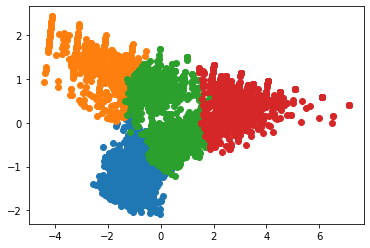

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in customer_clustering["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"]==i]
    plt.scatter(tmp[0], tmp[1])

In [37]:
"""クラスタリング結果を基に退会顧客の傾向を把握する"""
#クラスタリングによって4つのグループに分割されたが、これらのグループの継続顧客と退会顧客の数を調査し、集計する。
#最初に、退会顧客を特定するためにis_deleted列をcustomer_clusteringに追加し、cluster,is_deleted毎に集計を行う。

#グループ毎の退会／継続顧客の集計
customer_clustering = pd.concat([customer_clustering, customer], axis=1)
customer_clustering.groupby(["cluster", "is_deleted"], as_index=False).count()[["cluster", "is_deleted", "customer_id"]]

,cluster,is_deleted,customer_id
0,0,0,821
1,0,1,19
2,1,0,1231
3,1,1,18
4,2,1,771
5,3,0,790
6,3,1,542


In [38]:
#定期利用(Flg)しているかどうか
customer_clustering.groupby(["cluster", "routine_flg"], as_index=False).count()[["cluster", "routine_flg", "customer_id"]]

,cluster,routine_flg,customer_id
0,0,0,52
1,0,1,788
2,1,0,2
3,1,1,1247
4,2,0,499
5,2,1,272
6,3,0,226
7,3,1,1106


In [39]:
#クラスタリングの結果を分析
#上記の結果では、count()によりデータ件数を取っているので、どの列も同じになっている。
#顧客数の順位は、グループ3,1,0,2となっている。
#ここでグループ毎の平均値を取る
customer_clustering.groupby("cluster").mean()

,月内平均値,月内中央値,月内最大値,月内最小値,会員期間,is_deleted,price,mean,median,max,min,routine_flg,membership_period
cluster,,,,,,,,,,,,,
0,8.061942,8.047024,10.014286,6.175000,7.019048,0.022619,8500.000000,8.061942,8.047024,10.014286,6.175000,0.938095,7.019048
1,4.677561,4.670937,7.233787,2.153723,36.915933,0.014412,8579.663731,4.677561,4.670937,7.233787,2.153723,0.998399,36.915933
2,3.065504,2.900130,4.783398,1.649805,9.276265,1.000000,8587.548638,3.065504,2.900130,4.783398,1.649805,0.352789,9.276265
3,5.539535,5.391141,8.756006,2.702703,14.867868,0.406907,8563.063063,5.539535,5.391141,8.756006,2.702703,0.830330,14.867868


In [40]:
"""翌月の利用回数予測を行うための準備を行う"""
#顧客の過去の行動データから翌月の利用回数を予測するためには、教師あり学習の回帰を用いる。
#ここでは各6ヶ月の利用データを用いて、翌月の利用データを予測する。

#当月が2018年10月で2018年11月の利用回数を予測する。
#予測が目的なので、2018年5月〜10月の6ヶ月の利用データと2018年11月の利用回数を教師データとして学習に使うことにする。
#つまり、これまでの顧客データとは違いある特定の顧客の特定の月のデータを作成する必要がある。

#最初に，uselogデータを用いて年月、顧客毎に集計を行う。
uselog["usedate"] = pd.to_datetime(uselog["usedate"])
uselog["年月"] = uselog["usedate"].dt.strftime("%Y%m")
uselog_months = uselog.groupby(["年月", "customer_id"], as_index=False).count()
uselog_months.rename(columns={"log_id":"count"}, inplace=True)
del uselog_months["usedate"]
uselog_months.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [41]:
#データを整形
year_months = list(uselog_months["年月"].unique())
predict_data = pd.DataFrame()
for i in range(6, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
    tmp.rename(columns={"count":"count_pred"}, inplace=True)
    for j in range(1, 7):
        tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i-j]]
        del tmp_before["年月"]
        tmp_before.rename(columns={"count":"count_{}".format(j-1)}, inplace=True)
        tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    predict_data = pd.concat([predict_data, tmp], ignore_index=True)
predict_data.head()

/home/vagrant/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS008805,2,2.0,5.0,7.0,8.0,NaN,NaN
2,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
3,201810,AS015233,7,9.0,11.0,5.0,7.0,7.0,NaN
4,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0


In [42]:
#欠損値を含むデータを除去(dropna),indexを初期化
predict_data = predict_data.dropna()
predict_data = predict_data.reset_index(drop=True)
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0


In [43]:
#特徴となるデータを付与する
#会員期間を付与する
#顧客データであるcustomerのstart_dateの列を先に作成したpredict_dataに結合する
predict_data = pd.merge(predict_data, customer[["customer_id", "start_date"]], on = "customer_id", how = "left")
predict_data.head()

,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01


In [44]:
#年月とstart_dateの差から、会員期間を月単位で作成。
predict_data["now_date"] = pd.to_datetime(predict_data["年月"], format="%Y%m")
predict_data["start_date"] = pd.to_datetime(predict_data["start_date"])

from dateutil.relativedelta import relativedelta
predict_data["period"] = None
for i in range(len(predict_data)):
    delta = relativedelta(predict_data["now_date"][i], predict_data["start_date"][i])
    predict_data["period"][i] = delta.years*12 + delta.months
predict_data.head()

<ipython-input-44-6e3862a91078>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data["period"][i] = delta.years*12 + delta.months


,年月,customer_id,count_pred,count_0,count_1,count_2,count_3,count_4,count_5,start_date,now_date,period
0,201810,AS002855,3,7.0,3.0,5.0,5.0,5.0,4.0,2016-11-01,2018-10-01,23
1,201810,AS009373,5,6.0,6.0,7.0,4.0,4.0,3.0,2015-11-01,2018-10-01,35
2,201810,AS015315,4,7.0,3.0,6.0,3.0,3.0,6.0,2015-07-01,2018-10-01,39
3,201810,AS015739,5,6.0,5.0,8.0,6.0,5.0,7.0,2017-06-01,2018-10-01,16
4,201810,AS019860,7,5.0,7.0,4.0,6.0,8.0,6.0,2017-10-01,2018-10-01,12


In [45]:
"""来月の予測モデルを作成する。"""
#2018年4月以降に新規に入った顧客に絞ってモデル作成を行う。
#古い顧客は、入店時期のデータが存在せず、利用回数が安定状態にある可能性があるので、今回はデータ対象外として除外する。

#線形回帰モデル=>LinerRegression(scikit-learn)と呼ばれる回帰モデルを使用する。
#データを学習用データと評価用データに分割して、学習を行う。
predict_data = predict_data.loc[predict_data["start_date"] >= pd.to_datetime("20180401")]

from sklearn import linear_model
import sklearn.model_selection

model = linear_model.LinearRegression()
X = predict_data[["count_0","count_1","count_2","count_3","count_4","count_5","period"]]
y = predict_data["count_pred"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y)
model.fit(X_train, y_train)

LinearRegression()

In [46]:
#精度の検証
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.615075451743552
0.583130405244831


In [47]:
#モデルに寄与している変数を確認
#説明変数毎に、寄与している変数の係数を出力してみる。
coef = pd.DataFrame({"feature_names":X.columns, "coefficient":model.coef_})
coef

,feature_names,coefficient
0,count_0,0.343673
1,count_1,0.197050
2,count_2,0.170355
3,count_3,0.186622
4,count_4,0.067084
5,count_5,0.076147
6,period,0.096623


In [48]:
#来月の利用回数を予測する
#2人の顧客の利用データを作成する。1人目は6ヶ月前から1ヶ月毎に7，8，6，4，4，3回来ている顧客で、2人目は6，4，3，3，2，2回来ている顧客で、どちらも8ヶ月の在籍期間の顧客の翌月の来店回数を予測する。
#それぞれの顧客の利用履歴をリストに格納し、データを作成する。
x1 = [3,4,4,6,8,7,8]
x2 = [2,2,3,3,4,6,8]
x_pred = [x1, x2]
#modelを用いて予測を行う。
model.predict(x_pred)

array([3.81764229, 2.005163  ])

In [49]:
#uselog_monthsデータを出力
uselog_months.to_csv("use_log_months.csv", index=False)

In [55]:
"""顧客の退会を予測する"""
#退会してしまう会員が退会する原因を分析する。

#データの読み込み。利用データ整形。
import pandas as pd

customer = pd.read_csv('customer_join.csv')
uselog_months = pd.read_csv('use_log_months.csv')

#機械学習用にデータを加工=>未来を予測
#当月と過去1ヶ月の利用回数を集計したデータを作成
year_months = list(uselog_months["年月"].unique())
uselog = pd.DataFrame()
for i in range(1, len(year_months)):
    tmp = uselog_months.loc[uselog_months["年月"]==year_months[i]]
    tmp.rename(columns={"count":"count_0"}, inplace=True)
    tmp_before = uselog_months.loc[uselog_months["年月"]==year_months[i - 1]]
    del tmp_before["年月"]
    tmp_before.rename(columns={"count":"count_1"}, inplace=True)
    tmp = pd.merge(tmp, tmp_before, on="customer_id", how="left")
    uselog = pd.concat([uselog, tmp], ignore_index=True)

uselog.head()

/home/vagrant/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/vagrant/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
/home/vagrant/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/pandas/core/frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,年月,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


In [56]:
"""退会前月の退会顧客データを作成する"""
#退会前月のデータを作成するのは、退会申請は退会の前月末までに出すことのなっているからである。
#退会した顧客に絞り込んで、end_date列の1ヶ月前の年月を取得し、上記で整形したuselogとcustomer_id,年月をキーにして結合する。
from dateutil.relativedelta import relativedelta

exit_customer = customer.loc[customer["is_deleted"]==1]
exit_customer["exit_date"] = None
exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])

for i in range(len(exit_customer)):
    exit_customer["exit_date"].iloc[i] = exit_customer["end_date"].iloc[i] - relativedelta(months=1)

exit_customer["年月"] = exit_customer["exit_date"]
uselog["年月"] = uselog["年月"].astype(str)
exit_uselog = pd.merge(uselog, exit_customer, on=["customer_id", "年月"], how="left")
print(len(uselog))
exit_uselog.head()

<ipython-input-56-086ad99155bb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["exit_date"] = None
<ipython-input-56-086ad99155bb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["end_date"] = pd.to_datetime(exit_customer["end_date"])
/home/vagrant/.pyenv/versions/anaconda3-2021.05/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

33851


<ipython-input-56-086ad99155bb>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exit_customer["年月"] = exit_customer["exit_date"]


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaN,NaT,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
#欠損値の除去
exit_uselog = exit_uselog.dropna(subset=["name"])
print(len(exit_uselog))
print(len(exit_uselog["customer_id"].unique()))
exit_uselog.head()

0
0


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
